# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [168]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [169]:
my_path = "C:/Users/user/lighthouse/Midterm_Project/Predicting_Flight_Delays/workbench/data/"
df = pd.read_csv(my_path +'flights.csv')
df.head()

,fl_date,mkt_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,carrier,month,day_of_week,haul_length,route,flight_delayed
0,2018-05-04,DL,N754EV,BOS,"Boston, MA",RIC,"Richmond, VA",1455,1453.0,-2.0,...,0.0,0.0,0.0,0.0,Delta Air Lines,5,4,short,BOS-RIC,0
1,2019-12-09,UA,N828UA,MSY,"New Orleans, LA",EWR,"Newark, NJ",1515,1757.0,162.0,...,0.0,178.0,0.0,0.0,United Airlines,12,0,short,MSY-EWR,1
2,2019-12-20,AA,N763US,CLT,"Charlotte, NC",SAT,"San Antonio, TX",1610,1630.0,20.0,...,0.0,0.0,0.0,0.0,American Airlines,12,4,short,CLT-SAT,1
3,2019-07-14,DL,N961DL,ATL,"Atlanta, GA",PWM,"Portland, ME",2114,2114.0,0.0,...,0.0,0.0,0.0,0.0,Delta Air Lines,7,6,short,ATL-PWM,0
4,2019-04-08,AA,N679AW,PHX,"Phoenix, AZ",BOI,"Boise, ID",2021,2015.0,-6.0,...,0.0,0.0,0.0,0.0,American Airlines,4,0,short,PHX-BOI,0


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195872 entries, 0 to 195871
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fl_date              195872 non-null  object 
 1   mkt_unique_carrier   195872 non-null  object 
 2   tail_num             195872 non-null  object 
 3   origin               195872 non-null  object 
 4   origin_city_name     195872 non-null  object 
 5   dest                 195872 non-null  object 
 6   dest_city_name       195872 non-null  object 
 7   crs_dep_time         195872 non-null  int64  
 8   dep_time             195872 non-null  float64
 9   dep_delay            195872 non-null  float64
 10  taxi_out             195872 non-null  float64
 11  wheels_off           195872 non-null  float64
 12  wheels_on            195872 non-null  float64
 13  taxi_in              195872 non-null  float64
 14  crs_arr_time         195872 non-null  int64  
 15  arr_time         

In [171]:
df['carrier_encoded']=LabelEncoder().fit_transform(df.mkt_unique_carrier)
df['haul_encoded']=LabelEncoder().fit_transform(df.haul_length)
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400]
df['binned_dep'] = np.searchsorted(bins, df['crs_dep_time'].values)
df['binned_arr'] = np.searchsorted(bins, df['crs_arr_time'].values)
bins = [0, 1100, 4100, 10000]
df['binned_distance'] = np.searchsorted(bins, df['distance'].values)

In [172]:
df['flight_number'] = df['mkt_unique_carrier']
route_time_grouped = df.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

df = df.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df

,fl_date,mkt_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,...,haul_length,route,flight_delayed,carrier_encoded,haul_encoded,binned_dep,binned_arr,binned_distance,flight_number,average_route_time
0,2018-05-04,DL,N754EV,BOS,"Boston, MA",RIC,"Richmond, VA",1455,1453.0,-2.0,...,short,BOS-RIC,0,3,2,5,6,1,DL,125.024174
1,2019-07-14,DL,N961DL,ATL,"Atlanta, GA",PWM,"Portland, ME",2114,2114.0,0.0,...,short,ATL-PWM,0,3,2,8,8,1,DL,125.024174
2,2018-03-17,DL,N8836A,ATL,"Atlanta, GA",CSG,"Columbus, GA",1001,954.0,-7.0,...,short,ATL-CSG,1,3,2,4,4,1,DL,125.024174
3,2018-09-10,DL,N718TW,JFK,"New York, NY",SFO,"San Francisco, CA",700,700.0,0.0,...,medium,JFK-SFO,0,3,1,3,4,2,DL,125.024174
4,2019-08-14,DL,N8943A,CWA,"Mosinee, WI",MSP,"Minneapolis, MN",1546,1558.0,12.0,...,short,CWA-MSP,1,3,2,6,6,1,DL,125.024174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195867,2018-01-22,VX,N642VA,LAX,"Los Angeles, CA",SEA,"Seattle, WA",1500,1453.0,-7.0,...,short,LAX-SEA,0,9,2,5,6,1,VX,208.322115
195868,2018-01-14,VX,N922VA,LAS,"Las Vegas, NV",SFO,"San Francisco, CA",1050,1039.0,-11.0,...,short,LAS-SFO,0,9,2,4,5,1,VX,208.322115
195869,2018-03-27,VX,N521VA,LAX,"Los Angeles, CA",EWR,"Newark, NJ",1355,1346.0,-9.0,...,medium,LAX-EWR,0,9,1,5,8,2,VX,208.322115
195870,2018-03-22,VX,N621VA,FLL,"Fort Lauderdale, FL",SFO,"San Francisco, CA",1850,1955.0,65.0,...,long,FLL-SFO,1,9,0,7,8,2,VX,208.322115


In [173]:
# numeric_features = [i for i in df.columns if df[i].dtypes!='O']
# print(numeric_features)
# num_df = df[numeric_features]
# num_df.info()

In [174]:
categorical_features = [i for i in df.columns if df[i].dtypes=='O']
print(categorical_features)

['fl_date', 'mkt_unique_carrier', 'tail_num', 'origin', 'origin_city_name', 'dest', 'dest_city_name', 'dup', 'carrier', 'haul_length', 'route', 'flight_number']


In [175]:
cat_df = df[categorical_features]
cat_df.head()

,fl_date,mkt_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,dup,carrier,haul_length,route,flight_number
0,2018-05-04,DL,N754EV,BOS,"Boston, MA",RIC,"Richmond, VA",N,Delta Air Lines,short,BOS-RIC,DL
1,2019-07-14,DL,N961DL,ATL,"Atlanta, GA",PWM,"Portland, ME",N,Delta Air Lines,short,ATL-PWM,DL
2,2018-03-17,DL,N8836A,ATL,"Atlanta, GA",CSG,"Columbus, GA",N,Delta Air Lines,short,ATL-CSG,DL
3,2018-09-10,DL,N718TW,JFK,"New York, NY",SFO,"San Francisco, CA",N,Delta Air Lines,medium,JFK-SFO,DL
4,2019-08-14,DL,N8943A,CWA,"Mosinee, WI",MSP,"Minneapolis, MN",N,Delta Air Lines,short,CWA-MSP,DL


In [176]:
# df.isnull().sum()

In [177]:
numeric_features = [i for i in df.columns if df[i].dtypes!='O']
print(numeric_features)
num_df = df[numeric_features]
num_df.head()

['crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'month', 'day_of_week', 'flight_delayed', 'carrier_encoded', 'haul_encoded', 'binned_dep', 'binned_arr', 'binned_distance', 'average_route_time']


,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,...,late_aircraft_delay,month,day_of_week,flight_delayed,carrier_encoded,haul_encoded,binned_dep,binned_arr,binned_distance,average_route_time
0,1455,1453.0,-2.0,20.0,1513.0,1631.0,4.0,1649,1635.0,-14.0,...,0.0,5,4,0,3,2,5,6,1,125.024174
1,2114,2114.0,0.0,12.0,2126.0,2339.0,2.0,2355,2341.0,-14.0,...,0.0,7,6,0,3,2,8,8,1,125.024174
2,1001,954.0,-7.0,34.0,1028.0,1055.0,3.0,1045,1058.0,13.0,...,0.0,3,5,1,3,2,4,4,1,125.024174
3,700,700.0,0.0,22.0,722.0,958.0,8.0,1024,1006.0,-18.0,...,0.0,9,0,0,3,1,3,4,2,125.024174
4,1546,1558.0,12.0,25.0,1623.0,1703.0,2.0,1654,1705.0,11.0,...,0.0,8,2,1,3,2,6,6,1,125.024174


In [178]:
final_num_df = num_df.copy()
final_num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195872 entries, 0 to 195871
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   crs_dep_time         195872 non-null  int64  
 1   dep_time             195872 non-null  float64
 2   dep_delay            195872 non-null  float64
 3   taxi_out             195872 non-null  float64
 4   wheels_off           195872 non-null  float64
 5   wheels_on            195872 non-null  float64
 6   taxi_in              195872 non-null  float64
 7   crs_arr_time         195872 non-null  int64  
 8   arr_time             195872 non-null  float64
 9   arr_delay            195872 non-null  float64
 10  cancelled            195872 non-null  float64
 11  crs_elapsed_time     195872 non-null  float64
 12  actual_elapsed_time  195872 non-null  float64
 13  air_time             195872 non-null  float64
 14  distance             195872 non-null  float64
 15  carrier_delay    

In [179]:
final_num_df = final_num_df.filter(['dep_delay','taxi_out', 'taxi_in', 'actual_elapsed_time', 'month','flight_delayed', 'day_of_week', 'carrier_encoded', 
                                    'haul_encoded', 'binned_dep', 'binned_arr', 'binned_distance', 'average_route_time'])

In [180]:
test_path = "C:/Users/user/lighthouse/Midterm_Project/Predicting_Flight_Delays/workbench/data/"
test = pd.read_csv(my_path +'flights_test.csv')
test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,2020-01-01,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,2020-01-01,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,2020-01-01,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


In [181]:
test_df =  test[['fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest']]

# Model

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [182]:
X = final_num_df
y = df['arr_delay']


In [183]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 4.175483
Best score using built-in LassoCV: 0.957243


In [184]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 9 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

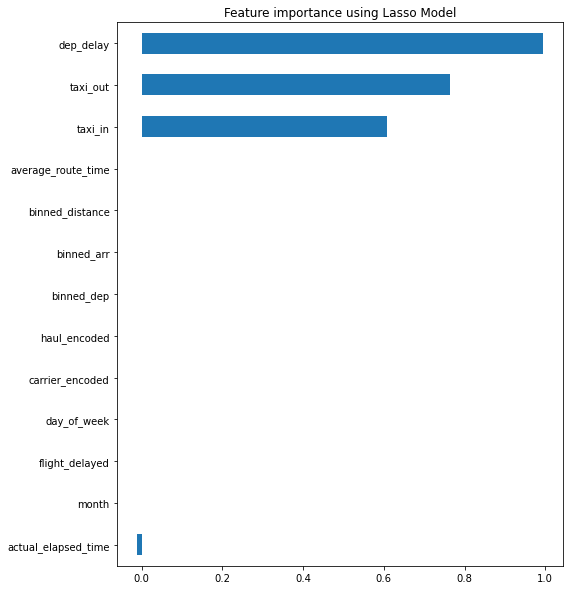

In [185]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [188]:
X.shape

(195872, 13)

In [189]:
y.shape

(195872,)

# Linear

In [205]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(137110, 13)
(58762, 13)


In [206]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_train_lr= lr.predict(X_train)

print(np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print(r2_score(y_train, pred_train_lr))

pred_test_lr= lr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print(r2_score(y_test, pred_test_lr))

# y_pred = lr_baseline.predict(X_test)

# r2_baseline = r2_score(y_test, y_pred)
# MSE_baseline = mean_squared_error(y_test,y_pred) 
# RMSE_baseline = mean_squared_error(y_test,y_pred,squared=False)
# MAE_baseline = mean_absolute_error(y_test,y_pred)
# print(f' r2: {r2_baseline}\n MSE: {MSE_baseline}\n MAE: {MAE_baseline}\n')

9.312810451076235
0.9646578766802224
9.313897495533245
0.9634124046893353


# Ridge Regression

In [155]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

9.34478632401676
0.9643847865755347
9.238882372073986
0.9640719179509487


# Lasso

In [156]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

9.345149036190227
0.964382021756367
9.23902769436395
0.9640707876860509


In [157]:
from sklearn.linear_model import ElasticNet

In [207]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

9.3142581994011
0.9646468874139389
9.317007718584309
0.9633879649566766


# Decision Tree

In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [209]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train,y_train)

x_check = dt.predict(X_train)
Train = accuracy_score(y_train, x_check)

y_model = dt.predict(X_test)
Test = accuracy_score(y_test, y_model)

#Print Results:
print("Decision Tree")
print("Training Accuracy: ", Train)
print("Testing Accuracy: ", Test)

Decision Tree
Training Accuracy:  0.051673838523813
Testing Accuracy:  0.05054286783976039


In [210]:
precision = precision_score(y_test, y_model, average='weighted')
recall = recall_score(y_test, y_model, average='weighted')
print('Avg Precision:', precision)
print('Avg Recall:', recall)

Avg Precision: 0.004012474674243574
Avg Recall: 0.05054286783976039


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XGBoost

In [ ]:
import xgboost as xgb
xgb1 = xgb.XGBRegressor(n_estimators=10000, max_depth=6)
xgb_tr=xgb1.fit(X_train,y_train)
print("Accuracy on training set for XGBoost(n=10000,depth=6): {:.3f}".format(xgb_tr.score(X_train, y_train)))


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [43]:
final_num_df

,dep_delay,taxi_out,taxi_in,actual_elapsed_time,month,day_of_week,carrier_encoded,binned_dep,binned_arr,binned_distance,average_route_time
0,-2.0,20.0,4.0,102.0,5,4,3,5,6,1,80.500000
1,122.0,10.0,3.0,59.0,4,1,3,6,6,1,80.500000
2,162.0,38.0,10.0,184.0,12,0,9,6,7,2,120.714286
3,15.0,10.0,9.0,165.0,9,0,9,6,7,2,120.714286
4,-3.0,18.0,3.0,67.0,2,6,9,5,5,1,120.714286
...,...,...,...,...,...,...,...,...,...,...,...
199995,-4.0,9.0,3.0,77.0,8,6,7,4,4,1,77.000000
199996,-3.0,22.0,5.0,154.0,12,1,3,7,8,1,154.000000
199997,-9.0,16.0,5.0,370.0,12,4,6,6,7,2,370.000000
199998,65.0,15.0,26.0,406.0,3,3,10,7,8,2,406.000000


In [56]:
from sklearn.preprocessing import StandardScaler
def scale(df):
    scaler = StandardScaler()
    ncol = ['dep_delay','taxi_out', 'taxi_in', 'actual_elapsed_time', 'month', 'day_of_week', 'carrier_encoded', 'binned_dep', 'binned_arr', 'binned_distance', 'average_route_time']
    final_num_df[ncol] = scaler.fit_transform(final_num_df[ncol])
    return df

In [57]:
def remove_highly_correlated_features(df, correlation_threshold=0.8):
    """ Any pair above the correlation threshold, one feature will be removed """
    
    df_corr = df.corr().abs()

    indices = np.where(df_corr > correlation_threshold)
    indices = [(df_corr.index[x], df_corr.columns[y])
    for x, y in zip(*indices)
        if x != y and x < y]

    for idx in indices: #each pair
        try:
            df.drop(idx[1], axis = 1, inplace=True)
        except KeyError:
            pass
    return df

In [59]:
fdf = scale(df)
fdf = remove_highly_correlated_features(df)

fdf

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,month,day_of_week,day_of_month,year,carrier_encoded,flight_number
0,2018-05-04,DL,DL_CODESHARE,Delta Airlines,5535,EV,N754EV,10721,BOS,"Boston, MA",...,0.0,0.0,0.0,0.0,5,4,4,2018,3,EV5535
1,2018-04-17,DL,DL_CODESHARE,Delta Airlines,5535,EV,N582CA,10397,ATL,"Atlanta, GA",...,0.0,0.0,0.0,0.0,4,1,17,2018,3,EV5535
2,2019-12-09,UA,UA,United Airlines,1754,UA,N828UA,13495,MSY,"New Orleans, LA",...,0.0,178.0,0.0,0.0,12,0,9,2019,9,UA1754
3,2019-09-09,UA,UA,United Airlines,1754,UA,N441UA,13495,MSY,"New Orleans, LA",...,0.0,0.0,0.0,0.0,9,0,9,2019,9,UA1754
4,2019-02-24,UA,UA,United Airlines,1754,UA,N75410,12266,IAH,"Houston, TX",...,0.0,0.0,0.0,0.0,2,6,24,2019,9,UA1754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2018-08-26,WN,WN,Southwest Airlines,6832,WN,N223WN,14893,SMF,"Sacramento, CA",...,0.0,0.0,0.0,0.0,8,6,26,2018,7,WN6832
199996,2019-12-10,DL,DL_CODESHARE,Delta Airlines,4799,9E,N299PQ,12478,JFK,"New York, NY",...,0.0,0.0,0.0,0.0,12,1,10,2019,3,9E4799
199997,2018-12-28,B6,B6,JetBlue Airways,2629,B6,N663JB,10721,BOS,"Boston, MA",...,0.0,0.0,0.0,0.0,12,4,28,2018,6,B62629
199998,2018-03-22,VX,VX,Virgin America,1349,VX,N621VA,11697,FLL,"Fort Lauderdale, FL",...,0.0,21.0,0.0,65.0,3,3,22,2018,10,VX1349


In [69]:
X = fdf
y = df.arr_delay

AttributeError: 'DataFrame' object has no attribute 'arr_delay'

In [67]:
import xgboost as xgb
xgb_reg = fdf
y_pred = xgb_reg.predict(fdf)
test_path = 'C:/Users/user/lighthouse/Midterm_Project/Predicting_Flight_Delays/workbench/data/'
df_t = pd.read_csv(test_path+'flights_test.csv')
s_pred = pd.Series(y_pred, name='predicted_delay')
df_results = pd.concat([df_flights_test, s_pred], axis=1)

AttributeError: 'DataFrame' object has no attribute 'predict'

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.